In [1]:
%pip install datasets transformers
%pip install bert_score
%pip install evaluate
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
/Users/nalishjain/Acad Sem 6/NLP-Assignments/A3_16/.venv/bin/python: No module named spacy
/Users/nalishjain/Acad Sem 6/NLP-Assignments/A3_16/.venv/bin/python: No module named spacy


In [27]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from datasets import load_dataset
from torchtext.datasets import multi30k, Multi30k
from torch import Tensor
import torch
import evaluate as E
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import Transformer
import math
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
from torch.utils.data import DataLoader




In [3]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

In [4]:

train_data = load_dataset("wmt16", "de-en", split="train[:50000]")
val_data = load_dataset("wmt16", "de-en", split="validation")
test_data = load_dataset("wmt16", "de-en", split="test")




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [5]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample['translation'][language])


UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = train_data
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [6]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)

def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for pair in batch:
        src_sample = pair['translation']['de']
        tgt_sample = pair['translation']['en']
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [14]:

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = train_data
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for id, (src, tgt) in enumerate(train_dataloader):

        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()
        tgt_out = tgt[1:, :]

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
        torch.cuda.empty_cache()


    return losses / len(list(train_dataloader))



def evaluate(model):
    model.eval()
    losses = 0

    val_iter = val_data
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        torch.cuda.empty_cache()

    return losses / len(list(val_dataloader))

In [20]:
bleu = E.load("bleu")
meteor_metric = E.load("meteor")
bertscore_metric = E.load("bertscore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
def decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys



def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

def test_metrics(model, data):
  model.eval()
  references = []
  predictions = []
  for id, pair in enumerate(data):

      src_sample = pair['translation']['de']
      tgt_sample = pair['translation']['en']

      predictions.append(translate(model, src_sample))
      references.append([tgt_sample])

  bleu_score = bleu.compute(predictions=predictions, references=references)
  meteor_score = meteor_metric.compute(predictions=predictions, references=references)
  bertscore_score = bertscore_metric.compute(predictions=predictions, references=references, lang="en")
  print(f'BLEU Score: {bleu_score}')
  print(f'METEOR Score: {meteor_score}')
  print(f'BERTScore: {bertscore_score}')

In [24]:
NUM_EPOCHS = 20
train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_epoch(transformer, optimizer)
    val_loss = evaluate(transformer)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))
    if epoch%5 == 0:
      test_metrics(transformer, val_data)


# function to generate output sequence using greedy algorithm


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 6.291, Val loss: 6.663, Epoch time = 178.122s
Epoch: 2, Train loss: 5.045, Val loss: 6.451, Epoch time = 164.588s
Epoch: 3, Train loss: 4.638, Val loss: 6.295, Epoch time = 163.578s
Epoch: 4, Train loss: 4.326, Val loss: 6.132, Epoch time = 159.406s
Epoch: 5, Train loss: 4.062, Val loss: 6.077, Epoch time = 162.009s


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU Score: {'bleu': 0.013682340942040714, 'precisions': [0.22588946913626629, 0.0336414192840918, 0.00513250449860952, 0.0008985494844037482], 'brevity_penalty': 1.0, 'length_ratio': 1.146222250931249, 'translation_length': 53234, 'reference_length': 46443}
METEOR Score: {'meteor': 0.16261839175866025}
BERTScore: {'precision': [0.8222177624702454, 0.7812402248382568, 0.8354225754737854, 0.8410438299179077, 0.8304511308670044, 0.8099940419197083, 0.789806604385376, 0.8024116158485413, 0.7648897767066956, 0.8044943809509277, 0.8246908187866211, 0.8482687473297119, 0.8319964408874512, 0.7974357604980469, 0.8281188011169434, 0.8039159774780273, 0.8213058114051819, 0.7824636101722717, 0.7754837870597839, 0.8160087466239929, 0.8210934400558472, 0.8402895331382751, 0.8011436462402344, 0.7993563413619995, 0.7914692163467407, 0.771939218044281, 0.8457214832305908, 0.7727530002593994, 0.7498586177825928, 0.8283172845840454, 0.772121787071228, 0.7820472717285156, 0.7676786780357361, 0.7814154624

In [36]:
# torch.save(transformer, 'model_2A.pt')
torch.save(transformer.state_dict(), '/content/drive/MyDrive/model_2A.pt')

# print("BLEU-1:", bleu_scores["bleu"])
# print("BLEU-2:", bleu_scores["bleu-2"])
# print("BLEU-3:", bleu_scores["bleu-3"])
# print("BLEU-4:", bleu_scores["bleu-4"])



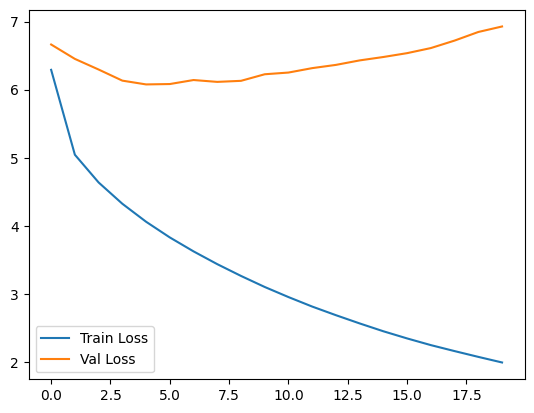

In [29]:
plt.plot(range(NUM_EPOCHS), train_losses, label = "Train Loss")
plt.plot(range(NUM_EPOCHS), val_losses, label = "Val Loss")
plt.legend()
plt.show()

Val Metrics

In [37]:
test_metrics(transformer, val_data)

BLEU Score: {'bleu': 0.03851418841522835, 'precisions': [0.2934494653986163, 0.06612326043737575, 0.01861547411285631, 0.006091458904407605], 'brevity_penalty': 1.0, 'length_ratio': 1.12975044678423, 'translation_length': 52469, 'reference_length': 46443}
METEOR Score: {'meteor': 0.2415273378585499}
BERTScore: {'precision': [0.8645802140235901, 0.8153248429298401, 0.8131167888641357, 0.871492326259613, 0.8557373285293579, 0.833263099193573, 0.8236299157142639, 0.8072503209114075, 0.816050112247467, 0.8308663964271545, 0.7837439179420471, 0.8517566919326782, 0.8333684802055359, 0.8257638216018677, 0.8301515579223633, 0.846435010433197, 0.834230899810791, 0.8210578560829163, 0.8356263041496277, 0.8494592308998108, 0.8483736515045166, 0.8546997904777527, 0.7988502383232117, 0.8448023796081543, 0.8124858140945435, 0.8265838623046875, 0.8498961925506592, 0.8297241926193237, 0.8249897956848145, 0.854217529296875, 0.8048496246337891, 0.8238492608070374, 0.8307496309280396, 0.8469269275665283,

Test Metrics

In [38]:
test_metrics(transformer, test_data)

BLEU Score: {'bleu': 0.044099405884553494, 'precisions': [0.2912421432320758, 0.07173913043478261, 0.022474048696212355, 0.008054513436949698], 'brevity_penalty': 1.0, 'length_ratio': 1.1587672920663141, 'translation_length': 74299, 'reference_length': 64119}
METEOR Score: {'meteor': 0.24615395968645679}
BERTScore: {'precision': [0.8262431621551514, 0.8347685933113098, 0.9094914197921753, 0.8600261807441711, 0.8661061525344849, 0.8514562845230103, 0.8450577259063721, 0.8359825611114502, 0.8629910349845886, 0.8134464621543884, 0.8106018304824829, 0.8303201794624329, 0.7933423519134521, 0.8099229335784912, 0.8161621689796448, 0.8784990310668945, 0.873075544834137, 0.8194614052772522, 0.8178238868713379, 0.8634800910949707, 0.8381189107894897, 0.8175090551376343, 0.8163115978240967, 0.8836888074874878, 0.8237420320510864, 0.8127129673957825, 0.8085861206054688, 0.8807680606842041, 0.8300731778144836, 0.8130459189414978, 0.8787040114402771, 0.7946170568466187, 0.8320053815841675, 0.8707951

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
